In [16]:
# ============================================================================
# CELDA 1: IMPORTS Y CONFIGURACIÓN INICIAL
# ============================================================================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt
from IPython import display
import sklearn.metrics as skm
import copy

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")
print(f"PyTorch version: {torch.__version__}")

Usando dispositivo: cuda:0
PyTorch version: 2.8.0+cu126


In [17]:
# ============================================================================
# SEMILLA DE REPRODUCIBILIDAD
# ============================================================================
def set_seed(seed=42):
    """Establece semilla para reproducibilidad"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Establecer semilla
set_seed(42)
print("Semilla de reproducibilidad establecida: 42")

Semilla de reproducibilidad establecida: 42


In [18]:
# ============================================================================
# CELDA 2: IMPORTAR Y PREPARAR EL DATASET
# ============================================================================
print("Descargando dataset EMNIST...")
cdata = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)

print(f"All classes: {cdata.classes}")
print(f"Data size: {cdata.data.shape}")

# Transformando a tensor 4D para capas convolucionales
images = cdata.data.view([124800, 1, 28, 28]).float()
print(f"Tensor shape: {images.shape}")

# Eliminar clase 0 y ajustar etiquetas
letterCategories = cdata.classes[1:]
labels = copy.deepcopy(cdata.targets) - 1
print(f"Labels shape: {labels.shape}")
print(f"Número de muestras con label 0: {torch.sum(labels == 0)}")

# Normalizar imágenes
images /= torch.max(images)
print("Imágenes normalizadas al rango [0, 1]")

Descargando dataset EMNIST...
All classes: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Data size: torch.Size([124800, 28, 28])
Tensor shape: torch.Size([124800, 1, 28, 28])
Labels shape: torch.Size([124800])
Número de muestras con label 0: 4800
Imágenes normalizadas al rango [0, 1]


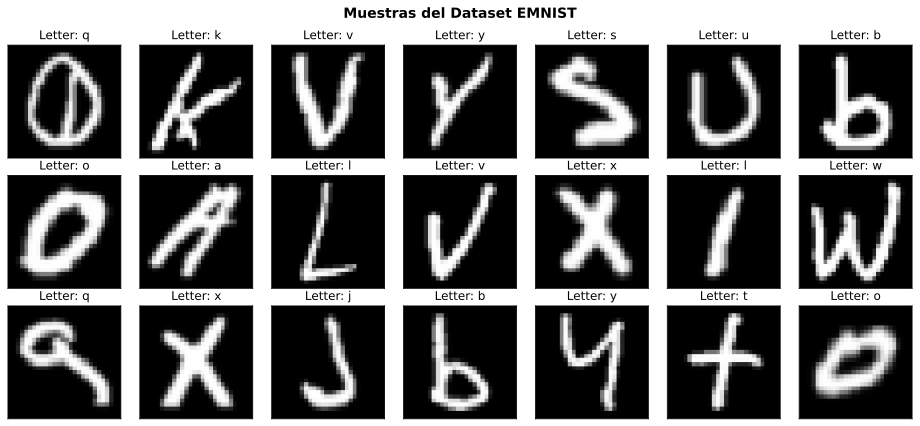

In [19]:
# ============================================================================
# CELDA 3: VISUALIZAR MUESTRAS DEL DATASET
# ============================================================================
fig, axes = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axes.flatten()):
    which_pic = np.random.randint(images.shape[0])

    image = images[which_pic, 0, :, :].detach()
    letter = letterCategories[labels[which_pic]]

    ax.imshow(image.T, cmap='gray')
    ax.set_title(f"Letter: {letter}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Muestras del Dataset EMNIST", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:
# ============================================================================
# CELDA 4: DIVISIÓN EN TRAIN/VALIDATION/TEST (75%/15%/15%)
# ============================================================================
print("\n" + "="*60)
print("DIVISIÓN DEL DATASET")
print("="*60)

# Primera división: 75% train, 25% temp (para val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.25, random_state=42, stratify=labels
)

# Segunda división: 15% validation, 15% test (50% de temp cada uno)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape[0]} muestras ({X_train.shape[0]/len(images)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} muestras ({X_val.shape[0]/len(images)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} muestras ({X_test.shape[0]/len(images)*100:.1f}%)")

# Crear datasets y dataloaders
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 128
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_dl)}")
print(f"Validation batches: {len(val_dl)}")
print(f"Test batches: {len(test_dl)}")


DIVISIÓN DEL DATASET
Train set: 93600 muestras (75.0%)
Validation set: 15600 muestras (12.5%)
Test set: 15600 muestras (12.5%)

Batch size: 128
Train batches: 731
Validation batches: 122
Test batches: 122


In [21]:
# ============================================================================
# CELDA 5: DEFINICIÓN DEL MODELO
# ============================================================================
def make_the_model(print_toggle):
    class EMNISTNet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            self.print_toggle = print_toggle

            # Conv1
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=64)

            # Conv2
            self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
            self.bnorm2 = nn.BatchNorm2d(num_features=128)

            # Conv3
            self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
            self.bnorm3 = nn.BatchNorm2d(num_features=256)

            self.fc1 = nn.Linear(in_features=2*2*256, out_features=256)
            self.fc2 = nn.Linear(in_features=256, out_features=64)
            self.fc3 = nn.Linear(in_features=64, out_features=26)

        def forward(self, x):
            if self.print_toggle:
                print(f"Input: {list(x.shape)}")

            # First Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu((self.bnorm1(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"First Block: {list(x.shape)}")

            # Second Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu((self.bnorm2(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"Second Block: {list(x.shape)}")

            # Third Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu((self.bnorm3(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"Third Block: {list(x.shape)}")

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(n_units))
            if self.print_toggle:
                print(f"Vectorized: {list(x.shape)}")

            # Linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.fc3(x)
            if self.print_toggle:
                print(f"Final Output: {list(x.shape)}")

            return x

    model = EMNISTNet(print_toggle)
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    return model, loss_fun, optimizer

# Test del modelo
print("\n" + "="*60)
print("ARQUITECTURA DEL MODELO")
print("="*60)
model, loss_fun, optimizer = make_the_model(True)
X, y = next(iter(train_dl))
y_hat = model(X)
loss = loss_fun(y_hat, torch.squeeze(y))
print(f"\nOutput: {y_hat.shape} | Loss inicial: {loss.item():.4f}")


ARQUITECTURA DEL MODELO
Input: [128, 1, 28, 28]
First Block: [128, 64, 14, 14]
Second Block: [128, 128, 6, 6]
Third Block: [128, 256, 2, 2]
Vectorized: [128, 1024]
Final Output: [128, 26]

Output: torch.Size([128, 26]) | Loss inicial: 3.2722


In [22]:
# ============================================================================
# CELDA 6: CLASE EARLY STOPPING
# ============================================================================
class EarlyStopping:
    """Early stopping para detener el entrenamiento cuando la validación deja de mejorar."""

    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        """
        Args:
            patience (int): Cuántas épocas esperar después de la última mejora
            min_delta (float): Cambio mínimo para considerar una mejora
            verbose (bool): Si True, imprime mensajes
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} de {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Guarda el estado del modelo cuando la validación mejora."""
        if self.verbose:
            print(f'Validation loss mejoró a {self.best_loss:.6f}. Guardando modelo...')
        self.best_model_state = copy.deepcopy(model.state_dict())

print("Clase EarlyStopping definida correctamente")

Clase EarlyStopping definida correctamente


In [23]:
# ============================================================================
# CELDA 7: FUNCIÓN DE ENTRENAMIENTO CON FINE-TUNING
# ============================================================================
def train_the_model():
    """
    Entrena el modelo con:
    - Learning rate scheduler (ReduceLROnPlateau)
    - Early stopping
    - Validación en cada época
    """
    epochs = 30  # Máximo de épocas (early stopping puede detenerlo antes)
    model, loss_fun, optimizer = make_the_model(False)
    model = model.to(device)

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',           # Minimizar la loss de validación
        factor=0.5,           # Reducir LR a la mitad
        patience=3,           # Esperar 3 épocas sin mejora
        min_lr=1e-6
    )

    # Early Stopping
    early_stopping = EarlyStopping(patience=7, min_delta=0.001, verbose=True)

    # Métricas
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    learning_rates = []

    print("\n" + "="*60)
    print("INICIANDO ENTRENAMIENTO")
    print("="*60)

    for epoch_i in range(epochs):
        print(f"\n{'='*60}")
        print(f"ÉPOCA {epoch_i+1}/{epochs}")
        print(f"{'='*60}")

        # ======================= ENTRENAMIENTO =======================
        model.train()
        batch_loss = []
        batch_acc = []

        for X, y in tqdm(train_dl, desc=f"Entrenando Época {epoch_i+1}"):
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, torch.squeeze(y))
            batch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()
            batch_acc.append(acc)

        epoch_train_loss = np.mean(batch_loss)
        epoch_train_acc = np.mean(batch_acc)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # ======================= VALIDACIÓN =======================
        model.eval()
        val_batch_loss = []
        val_batch_acc = []

        with torch.no_grad():
            for X, y in tqdm(val_dl, desc=f"Validando Época {epoch_i+1}"):
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = loss_fun(y_hat, torch.squeeze(y))
                val_batch_loss.append(loss.item())

                acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()
                val_batch_acc.append(acc)

        epoch_val_loss = np.mean(val_batch_loss)
        epoch_val_acc = np.mean(val_batch_acc)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        # ======================= TEST =======================
        test_batch_loss = []
        test_batch_acc = []

        with torch.no_grad():
            for X, y in test_dl:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = loss_fun(y_hat, torch.squeeze(y))
                test_batch_loss.append(loss.item())

                acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()
                test_batch_acc.append(acc)

        epoch_test_loss = np.mean(test_batch_loss)
        epoch_test_acc = np.mean(test_batch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        # Guardar learning rate actual
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # ======================= RESUMEN DE ÉPOCA =======================
        print(f"\nResultados Época {epoch_i+1}:")
        print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}")
        print(f"  Test Loss:  {epoch_test_loss:.4f} | Test Acc:  {epoch_test_acc:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # ======================= SCHEDULER =======================
        scheduler.step(epoch_val_loss)

        # ======================= EARLY STOPPING =======================
        early_stopping(epoch_val_loss, model)

        if early_stopping.early_stop:
            print(f"\n{'='*60}")
            print(f"EARLY STOPPING activado en época {epoch_i+1}")
            print(f"{'='*60}")
            # Restaurar el mejor modelo
            model.load_state_dict(early_stopping.best_model_state)
            break

    print(f"\n{'='*60}")
    print("ENTRENAMIENTO COMPLETADO")
    print(f"{'='*60}")

    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, learning_rates, model

In [24]:
# ============================================================================
# CELDA 8: ENTRENAR EL MODELO
# ============================================================================
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, learning_rates, model = train_the_model()

print("\n¡Entrenamiento finalizado exitosamente!")


INICIANDO ENTRENAMIENTO

ÉPOCA 1/30


Entrenando Época 1:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 1:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 1:
  Train Loss: 0.8641 | Train Acc: 0.7348
  Val Loss:   0.2373 | Val Acc:   0.9202
  Test Loss:  0.2316 | Test Acc:  0.9200
  Learning Rate: 0.001000
Validation loss mejoró a 0.237317. Guardando modelo...

ÉPOCA 2/30


Entrenando Época 2:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 2:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 2:
  Train Loss: 0.3963 | Train Acc: 0.8800
  Val Loss:   0.2077 | Val Acc:   0.9335
  Test Loss:  0.1991 | Test Acc:  0.9338
  Learning Rate: 0.001000
Validation loss mejoró a 0.207683. Guardando modelo...

ÉPOCA 3/30


Entrenando Época 3:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 3:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 3:
  Train Loss: 0.3369 | Train Acc: 0.8977
  Val Loss:   0.2028 | Val Acc:   0.9381
  Test Loss:  0.1948 | Test Acc:  0.9389
  Learning Rate: 0.001000
Validation loss mejoró a 0.202767. Guardando modelo...

ÉPOCA 4/30


Entrenando Época 4:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 4:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 4:
  Train Loss: 0.3074 | Train Acc: 0.9073
  Val Loss:   0.1911 | Val Acc:   0.9359
  Test Loss:  0.1803 | Test Acc:  0.9345
  Learning Rate: 0.001000
Validation loss mejoró a 0.191095. Guardando modelo...

ÉPOCA 5/30


Entrenando Época 5:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 5:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 5:
  Train Loss: 0.2872 | Train Acc: 0.9135
  Val Loss:   0.1985 | Val Acc:   0.9361
  Test Loss:  0.1879 | Test Acc:  0.9376
  Learning Rate: 0.001000
EarlyStopping counter: 1 de 7

ÉPOCA 6/30


Entrenando Época 6:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 6:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 6:
  Train Loss: 0.2704 | Train Acc: 0.9165
  Val Loss:   0.1889 | Val Acc:   0.9446
  Test Loss:  0.1759 | Test Acc:  0.9451
  Learning Rate: 0.001000
Validation loss mejoró a 0.188922. Guardando modelo...

ÉPOCA 7/30


Entrenando Época 7:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 7:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 7:
  Train Loss: 0.2592 | Train Acc: 0.9212
  Val Loss:   0.1846 | Val Acc:   0.9418
  Test Loss:  0.1724 | Test Acc:  0.9418
  Learning Rate: 0.001000
Validation loss mejoró a 0.184579. Guardando modelo...

ÉPOCA 8/30


Entrenando Época 8:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 8:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 8:
  Train Loss: 0.2468 | Train Acc: 0.9243
  Val Loss:   0.1852 | Val Acc:   0.9444
  Test Loss:  0.1752 | Test Acc:  0.9447
  Learning Rate: 0.001000
EarlyStopping counter: 1 de 7

ÉPOCA 9/30


Entrenando Época 9:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 9:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 9:
  Train Loss: 0.2398 | Train Acc: 0.9254
  Val Loss:   0.1761 | Val Acc:   0.9479
  Test Loss:  0.1661 | Test Acc:  0.9459
  Learning Rate: 0.001000
Validation loss mejoró a 0.176130. Guardando modelo...

ÉPOCA 10/30


Entrenando Época 10:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 10:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 10:
  Train Loss: 0.2340 | Train Acc: 0.9277
  Val Loss:   0.1831 | Val Acc:   0.9421
  Test Loss:  0.1709 | Test Acc:  0.9438
  Learning Rate: 0.001000
EarlyStopping counter: 1 de 7

ÉPOCA 11/30


Entrenando Época 11:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 11:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 11:
  Train Loss: 0.2238 | Train Acc: 0.9293
  Val Loss:   0.1823 | Val Acc:   0.9443
  Test Loss:  0.1700 | Test Acc:  0.9437
  Learning Rate: 0.001000
EarlyStopping counter: 2 de 7

ÉPOCA 12/30


Entrenando Época 12:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 12:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 12:
  Train Loss: 0.2161 | Train Acc: 0.9320
  Val Loss:   0.1815 | Val Acc:   0.9477
  Test Loss:  0.1712 | Test Acc:  0.9464
  Learning Rate: 0.001000
EarlyStopping counter: 3 de 7

ÉPOCA 13/30


Entrenando Época 13:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 13:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 13:
  Train Loss: 0.2136 | Train Acc: 0.9325
  Val Loss:   0.1794 | Val Acc:   0.9457
  Test Loss:  0.1652 | Test Acc:  0.9486
  Learning Rate: 0.001000
EarlyStopping counter: 4 de 7

ÉPOCA 14/30


Entrenando Época 14:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 14:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 14:
  Train Loss: 0.1924 | Train Acc: 0.9388
  Val Loss:   0.1755 | Val Acc:   0.9489
  Test Loss:  0.1628 | Test Acc:  0.9494
  Learning Rate: 0.000500
EarlyStopping counter: 5 de 7

ÉPOCA 15/30


Entrenando Época 15:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 15:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 15:
  Train Loss: 0.1815 | Train Acc: 0.9410
  Val Loss:   0.1765 | Val Acc:   0.9497
  Test Loss:  0.1623 | Test Acc:  0.9512
  Learning Rate: 0.000500
EarlyStopping counter: 6 de 7

ÉPOCA 16/30


Entrenando Época 16:   0%|          | 0/731 [00:00<?, ?it/s]

Validando Época 16:   0%|          | 0/122 [00:00<?, ?it/s]


Resultados Época 16:
  Train Loss: 0.1786 | Train Acc: 0.9415
  Val Loss:   0.1782 | Val Acc:   0.9505
  Test Loss:  0.1650 | Test Acc:  0.9497
  Learning Rate: 0.000500
EarlyStopping counter: 7 de 7

EARLY STOPPING activado en época 16

ENTRENAMIENTO COMPLETADO

¡Entrenamiento finalizado exitosamente!


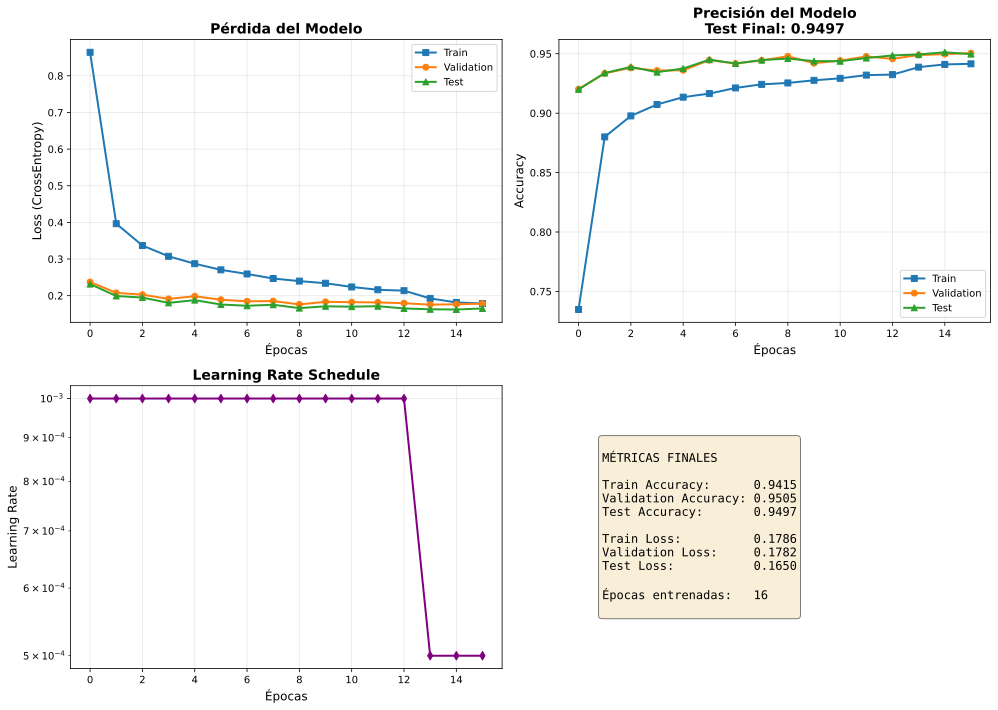

In [25]:
# ============================================================================
# CELDA 9: VISUALIZAR RESULTADOS DEL ENTRENAMIENTO
# ============================================================================
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Loss
ax[0, 0].plot(train_loss, "s-", label="Train", linewidth=2)
ax[0, 0].plot(val_loss, "o-", label="Validation", linewidth=2)
ax[0, 0].plot(test_loss, "^-", label="Test", linewidth=2)
ax[0, 0].set_xlabel("Épocas", fontsize=12)
ax[0, 0].set_ylabel("Loss (CrossEntropy)", fontsize=12)
ax[0, 0].set_title("Pérdida del Modelo", fontsize=14, fontweight='bold')
ax[0, 0].legend(fontsize=10)
ax[0, 0].grid(True, alpha=0.3)

# Accuracy
ax[0, 1].plot(train_acc, "s-", label="Train", linewidth=2)
ax[0, 1].plot(val_acc, "o-", label="Validation", linewidth=2)
ax[0, 1].plot(test_acc, "^-", label="Test", linewidth=2)
ax[0, 1].set_xlabel("Épocas", fontsize=12)
ax[0, 1].set_ylabel("Accuracy", fontsize=12)
ax[0, 1].set_title(f"Precisión del Modelo\nTest Final: {test_acc[-1]:.4f}",
                   fontsize=14, fontweight='bold')
ax[0, 1].legend(fontsize=10)
ax[0, 1].grid(True, alpha=0.3)

# Learning Rate
ax[1, 0].plot(learning_rates, "d-", color='purple', linewidth=2)
ax[1, 0].set_xlabel("Épocas", fontsize=12)
ax[1, 0].set_ylabel("Learning Rate", fontsize=12)
ax[1, 0].set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
ax[1, 0].set_yscale('log')
ax[1, 0].grid(True, alpha=0.3)

# Resumen de métricas finales
final_metrics = f"""
MÉTRICAS FINALES

Train Accuracy:      {train_acc[-1]:.4f}
Validation Accuracy: {val_acc[-1]:.4f}
Test Accuracy:       {test_acc[-1]:.4f}

Train Loss:          {train_loss[-1]:.4f}
Validation Loss:     {val_loss[-1]:.4f}
Test Loss:           {test_loss[-1]:.4f}

Épocas entrenadas:   {len(train_loss)}
"""

ax[1, 1].text(0.1, 0.5, final_metrics, fontsize=12, verticalalignment='center',
              fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()

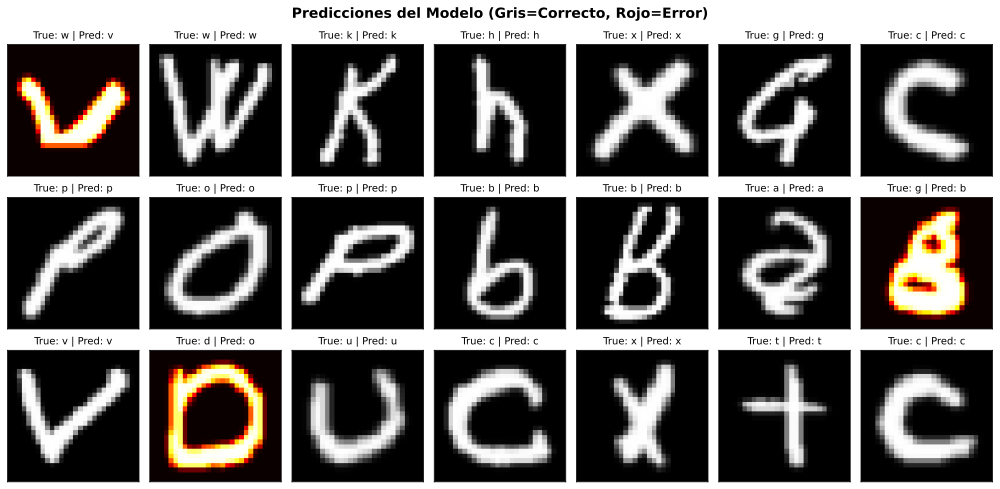

In [26]:
# ============================================================================
# CELDA 10: VISUALIZAR PREDICCIONES
# ============================================================================
# Obtener todas las predicciones del test set
model.eval()
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for X, y in test_dl:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        preds = torch.argmax(y_hat, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_images.extend(X.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_images = np.array(all_images)

# Visualizar predicciones
rand_idx = np.random.choice(len(all_labels), size=21, replace=False)

fig, axs = plt.subplots(3, 7, figsize=(14, 7))

for i, ax in enumerate(axs.flatten()):
    idx = rand_idx[i]
    image = np.squeeze(all_images[idx, 0, :, :])
    true_letter = letterCategories[all_labels[idx]]
    pred_letter = letterCategories[all_preds[idx]]

    cmap = "gray" if true_letter == pred_letter else "hot"

    ax.imshow(image.T, cmap=cmap)
    ax.set_title(f"True: {true_letter} | Pred: {pred_letter}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Predicciones del Modelo (Gris=Correcto, Rojo=Error)",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

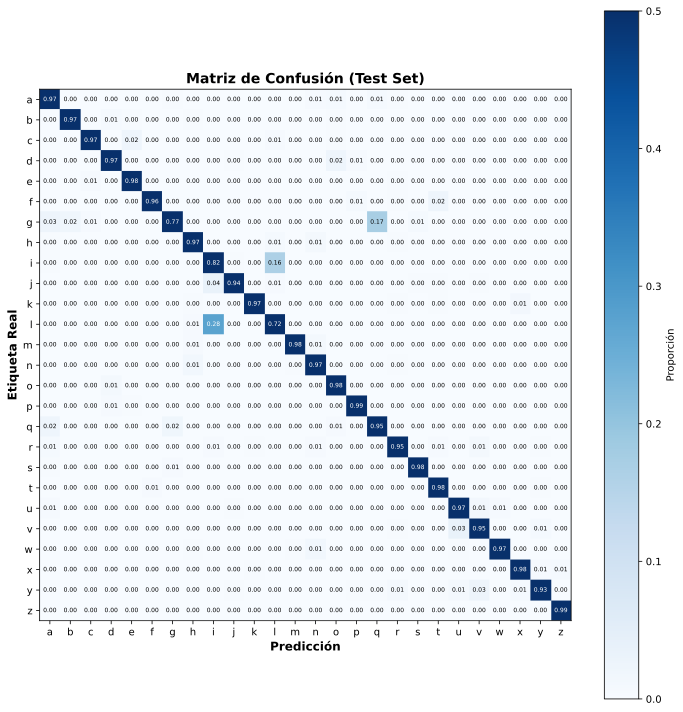

In [27]:
# ============================================================================
# CELDA 11: MATRIZ DE CONFUSIÓN
# ============================================================================
C = skm.confusion_matrix(all_labels, all_preds, normalize='true')

fig = plt.figure(figsize=(10, 10))
plt.imshow(C, "Blues", vmax=0.5)

plt.xticks(range(26), labels=letterCategories, fontsize=10)
plt.yticks(range(26), labels=letterCategories, fontsize=10)
plt.xlabel("Predicción", fontsize=12, fontweight='bold')
plt.ylabel("Etiqueta Real", fontsize=12, fontweight='bold')
plt.title("Matriz de Confusión (Test Set)", fontsize=14, fontweight='bold')
plt.colorbar(label='Proporción')

# Agregar valores en las celdas
for i in range(26):
    for j in range(26):
        text_color = 'white' if C[i, j] > 0.25 else 'black'
        plt.text(j, i, f'{C[i, j]:.2f}', ha='center', va='center',
                color=text_color, fontsize=6)

plt.tight_layout()
plt.show()

In [28]:
# ============================================================================
# CELDA 12: ANÁLISIS DETALLADO POR LETRA
# ============================================================================
# Calcular métricas por clase
from sklearn.metrics import classification_report

print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=letterCategories, digits=4))

# Encontrar las letras con mejor y peor rendimiento
accuracies_per_letter = np.diag(C)
sorted_indices = np.argsort(accuracies_per_letter)

print("\n" + "="*60)
print("ANÁLISIS POR LETRA")
print("="*60)
print("\n5 LETRAS CON MEJOR ACCURACY:")
for idx in sorted_indices[-5:][::-1]:
    print(f"  {letterCategories[idx]}: {accuracies_per_letter[idx]:.4f}")

print("\n5 LETRAS CON PEOR ACCURACY:")
for idx in sorted_indices[:5]:
    print(f"  {letterCategories[idx]}: {accuracies_per_letter[idx]:.4f}")

print("\n" + "="*60)
print("FIN DEL ANÁLISIS")
print("="*60)


REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

           a     0.9206    0.9667    0.9431       600
           b     0.9782    0.9717    0.9749       600
           c     0.9847    0.9683    0.9765       600
           d     0.9699    0.9667    0.9683       600
           e     0.9671    0.9800    0.9735       600
           f     0.9897    0.9617    0.9755       600
           g     0.9544    0.7667    0.8503       600
           h     0.9572    0.9700    0.9636       600
           i     0.7201    0.8233    0.7683       600
           j     0.9725    0.9433    0.9577       600
           k     0.9881    0.9717    0.9798       600
           l     0.7948    0.7167    0.7537       600
           m     0.9899    0.9817    0.9858       600
           n     0.9494    0.9700    0.9596       600
           o     0.9577    0.9817    0.9695       600
           p     0.9801    0.9867    0.9834       600
           q     0.8346    0.9500    0.8885       600
 